In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data & Features
We load the raw data and apply the *latest* feature engineering logic (Exp 17).

In [2]:
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, generate_training_data, aggregate_user_features

print("Loading Raw Data...")
train_df_raw = pd.read_parquet('../data/train.parquet')
test_df_raw = pd.read_parquet('../data/test.parquet')

print("Applying Feature Engineering (Exp 17)...")
# 1. Extract Attributes
train_df_raw = extract_user_attributes(train_df_raw)
test_df_raw = extract_user_attributes(test_df_raw)

# 2. Generate Training Data (Snapshots)
df_train = generate_training_data(train_df_raw)

# 3. Generate Test Data (Single Snapshot at End)
global_max_ts = test_df_raw['ts'].max()
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': global_max_ts
})
df_test = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)
df_test = df_test.reset_index(level='cutoff_ts', drop=True)

# Align Columns
cols_to_drop = ["target", "userId", "cutoff_ts"]
X_train = df_train.drop(columns=[c for c in cols_to_drop if c in df_train.columns])
X_test = df_test[X_train.columns]

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Loading Raw Data...
Applying Feature Engineering (Exp 17)...
Applying Feature Engineering (Exp 17)...
Generated 85807 snapshots.
Class Balance: 12.28%
Generated 85807 snapshots.
Class Balance: 12.28%
Train Shape: (85807, 40)
Test Shape: (2904, 40)
Train Shape: (85807, 40)
Test Shape: (2904, 40)


## 2. Covariate Shift Analysis
We compare the distribution of features in the Training Set (Snapshots) vs the Test Set (Full History).
Large divergences indicate "Toxic Features" that will confuse the model.

**Key Metric**: Mean Percentage Difference.
$$ \text{Diff} = \frac{\mu_{train} - \mu_{test}}{\mu_{train} + \epsilon} $$

Top 10 Most Divergent Features (Potential Toxicity):
                         mean_train  std_train  mean_test  std_test  \
log_errors_last_14d        0.106815   0.292508   0.223287  0.412793   
log_errors_last_30d        0.202135   0.401986   0.414621  0.543841   
log_errors_last_7d         0.058217   0.212426   0.118023  0.302849   
frustration_score          0.002208   0.008255   0.004419  0.010932   
log_songs_last_7d          2.002821   2.358454   3.637921  2.290284   
log_listen_time_last_7d    4.530782   4.988685   7.859341  4.461689   
errors_per_day             0.010064   0.019785   0.017272  0.056180   
log_songs_last_14d         2.807663   2.544698   4.724984  2.008520   
downgrade                  0.154614   0.361539   0.256543  0.436800   
trend_errors_7d_vs_30d     0.233247   0.870821   0.382000  1.023289   

                         mean_diff_pct  abs_diff_pct  
log_errors_last_14d          -1.090404      1.090404  
log_errors_last_30d          -1.051209      1.051209  


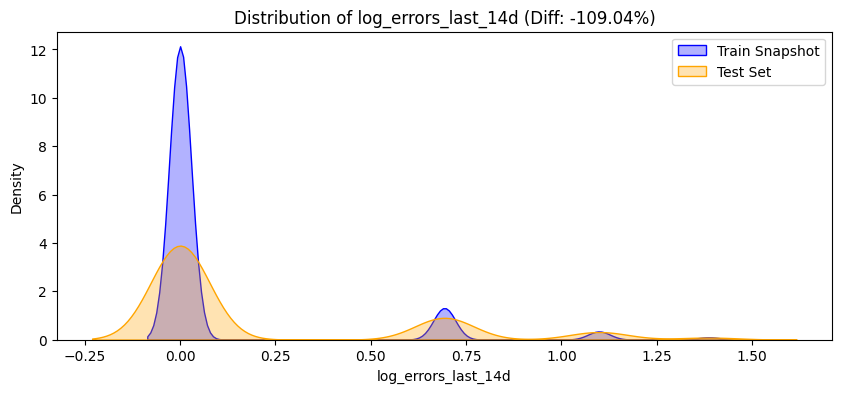

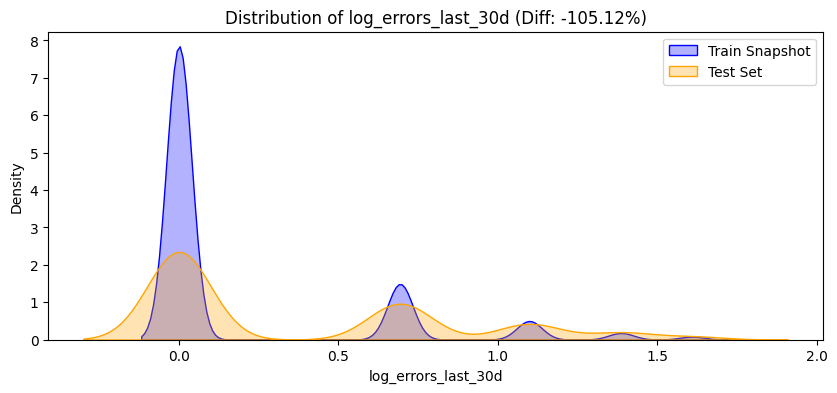

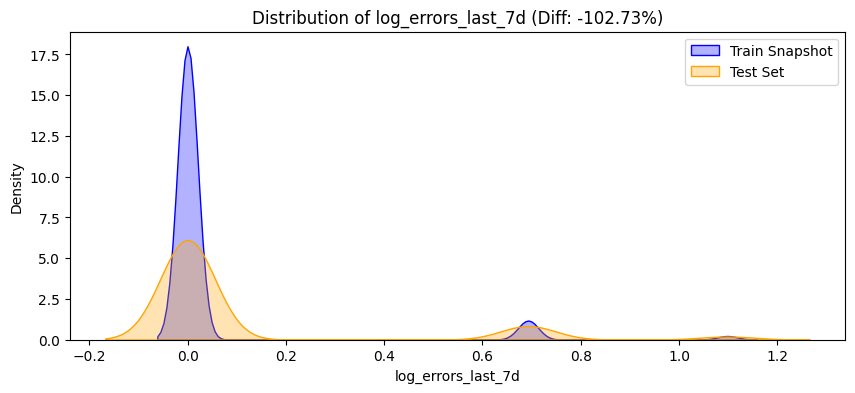

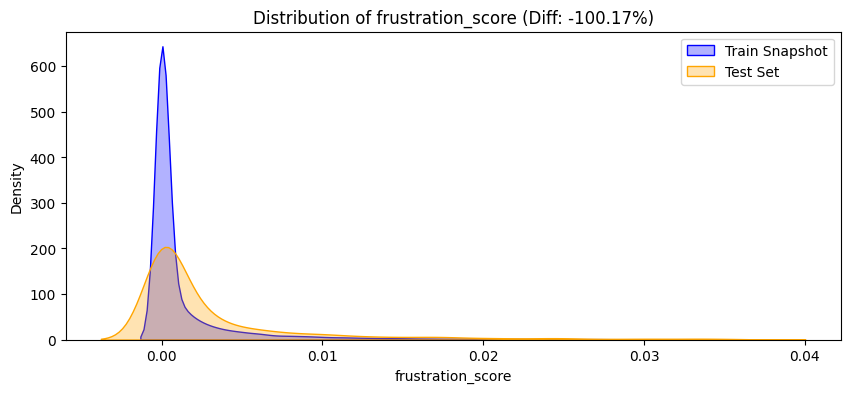

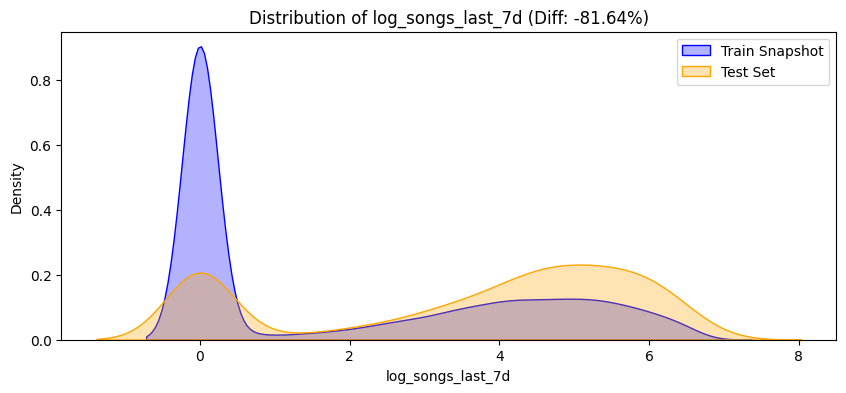

In [3]:
# Calculate Statistics
train_stats = X_train.describe().T[['mean', 'std']]
test_stats = X_test.describe().T[['mean', 'std']]

# Compare
comparison = train_stats.join(test_stats, lsuffix='_train', rsuffix='_test')
comparison['mean_diff_pct'] = (comparison['mean_train'] - comparison['mean_test']) / (comparison['mean_train'] + 1e-9)
comparison['abs_diff_pct'] = comparison['mean_diff_pct'].abs()

print("Top 10 Most Divergent Features (Potential Toxicity):")
print(comparison.sort_values(by='abs_diff_pct', ascending=False).head(10))

# Plot Top 5 Divergent Features
top_divergent = comparison.sort_values(by='abs_diff_pct', ascending=False).head(5).index.tolist()

for f in top_divergent:
    plt.figure(figsize=(10, 4))
    # Clip outliers for better visualization
    q99 = X_train[f].quantile(0.99)
    data_train = X_train[X_train[f] <= q99][f]
    data_test = X_test[X_test[f] <= q99][f]
    
    sns.kdeplot(data_train, label='Train Snapshot', fill=True, color='blue', alpha=0.3)
    sns.kdeplot(data_test, label='Test Set', fill=True, color='orange', alpha=0.3)
    plt.title(f"Distribution of {f} (Diff: {comparison.loc[f, 'mean_diff_pct']:.2%})")
    plt.legend()
    plt.show()

## 3. Feature Importance Analysis
We load the trained model (Last Exp) and analyze which features are driving the predictions.

Loading model from ../models/stacking_model.joblib...
Analyzing Voting Ensemble Importance...
✅ Retrieved fitted preprocessor from ensemble.
✅ Retrieved 40 transformed feature names.

Top 20 Features:
                                     xgb  lgbm        cat        rf  \
num__days_since_last_session    0.099344   473  28.256291  0.068429   
num__songs_per_minute           0.018834   329   2.053995  0.025489   
num__state_freq                 0.018744   310   2.386350  0.021487   
num__ads_per_day                0.025960   295   2.774297  0.049545   
num__account_lifetime           0.025251   285   5.453147  0.035355   
num__thumbs_ratio               0.023507   260   4.698948  0.040137   
num__avg_songs_per_session      0.020710   225   1.897550  0.023855   
num__avg_session_duration       0.020234   220   0.970993  0.025253   
num__diversity_ratio_30d        0.021365   215   4.030795  0.023379   
num__thumbs_up_per_day          0.019530   199   7.254629  0.028203   
num__recency_frequ

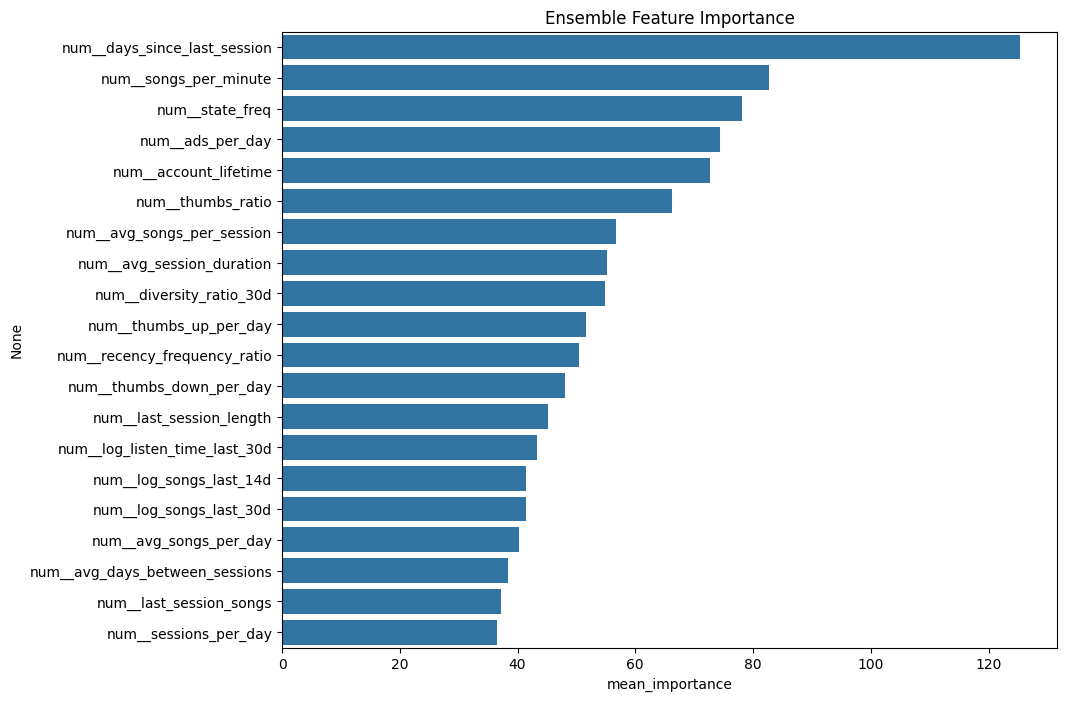

In [4]:
# Load Model
model_path = "../models/stacking_model.joblib"
if os.path.exists(model_path):
    print(f"Loading model from {model_path}...")
    model = joblib.load(model_path)
    
    # Extract Feature Names
    # Try to load from file first
    features_path = "../models/feature_names.joblib"
    if os.path.exists(features_path):
        feature_names = joblib.load(features_path)
    else:
        feature_names = X_train.columns

    # Analyze Importance (if VotingClassifier)
    if hasattr(model, 'estimators_'):
        print("Analyzing Voting Ensemble Importance...")
        
        # Attempt to get fitted preprocessor from the first estimator of the ensemble
        # This avoids the "not fitted" error from loading the separate preprocessor file
        fitted_preprocessor = None
        try:
            # model.estimators_[0] is the first fitted pipeline (e.g. XGBoost pipeline)
            first_pipe = model.estimators_[0]
            if hasattr(first_pipe, 'named_steps') and 'preprocessor' in first_pipe.named_steps:
                fitted_preprocessor = first_pipe.named_steps['preprocessor']
                print("✅ Retrieved fitted preprocessor from ensemble.")
        except Exception as e:
            print(f"⚠️ Could not extract preprocessor from ensemble: {e}")

        if fitted_preprocessor:
             try:
                transformed_names = fitted_preprocessor.get_feature_names_out()
                print(f"✅ Retrieved {len(transformed_names)} transformed feature names.")
             except Exception as e:
                 print(f"⚠️ Could not get transformed names from fitted preprocessor: {e}")
                 transformed_names = feature_names
        else:
             # Fallback (likely to fail if OHE is used, but better than nothing)
             print("⚠️ Using raw feature names (might mismatch if OHE was used).")
             transformed_names = feature_names

        # Collect Importances
        importances = []
        # Iterate over FITTED estimators
        for (name, _), fitted_pipe in zip(model.estimators, model.estimators_):
            if hasattr(fitted_pipe, 'named_steps') and 'classifier' in fitted_pipe.named_steps:
                clf = fitted_pipe.named_steps['classifier']
                if hasattr(clf, 'feature_importances_'):
                    imp = clf.feature_importances_
                    
                    if hasattr(imp, '__len__'):
                        # Check length match
                        if len(imp) == len(transformed_names):
                            importances.append(pd.Series(imp, index=transformed_names, name=name))
                        else:
                            print(f"⚠️ Shape mismatch for {name}: Model {len(imp)} vs Names {len(transformed_names)}")
                            # Fallback: Create dummy names if mismatch persists
                            if len(imp) > len(transformed_names):
                                print("   (Model has more features than names - likely OHE expansion)")
                            
                    else:
                        print(f"⚠️ {name} feature_importances_ is not array-like (Type: {type(imp)})")
        
        if importances:
            imp_df = pd.concat(importances, axis=1)
            imp_df['mean_importance'] = imp_df.mean(axis=1)
            imp_df = imp_df.sort_values(by='mean_importance', ascending=False)
            
            print("\nTop 20 Features:")
            print(imp_df.head(20))
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x='mean_importance', y=imp_df.head(20).index, data=imp_df.head(20))
            plt.title("Ensemble Feature Importance")
            plt.show()
        else:
            print("Could not extract feature importances from base estimators.")
else:
    print("Model not found. Run Modeling.ipynb first.")